In [9]:
import matplotlib.pyplot as plt
import numpy as np 
import json
from scipy import linalg

from common_utilities import generate_ssm, RandomState, rmse, plot_car_trajectory

In [10]:
#Parameters

q = 1.0  #process noise scalar
dt = 0.1 #Time step size 
s = 0.5  #Standard deviation of observation noise

M = 4 #State dimension: [x, y, vx, vy]
N = 2 #Observation dimension: [x, y]


# State transition matrix
# This explains/models how the state evolves over time 
# assuming that there is a constant velicity within the 2d space
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

#Process noise covariance matrix
#models the uncertainty in the state evolution
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

#Observation Matrix, maps full state to the observed positon
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

#observation noise covariance matrix
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

#Initial state
#Position is at (0,0), velocity is at (1, -1)
x_0 = np.array([0., 0., 1., -1.])

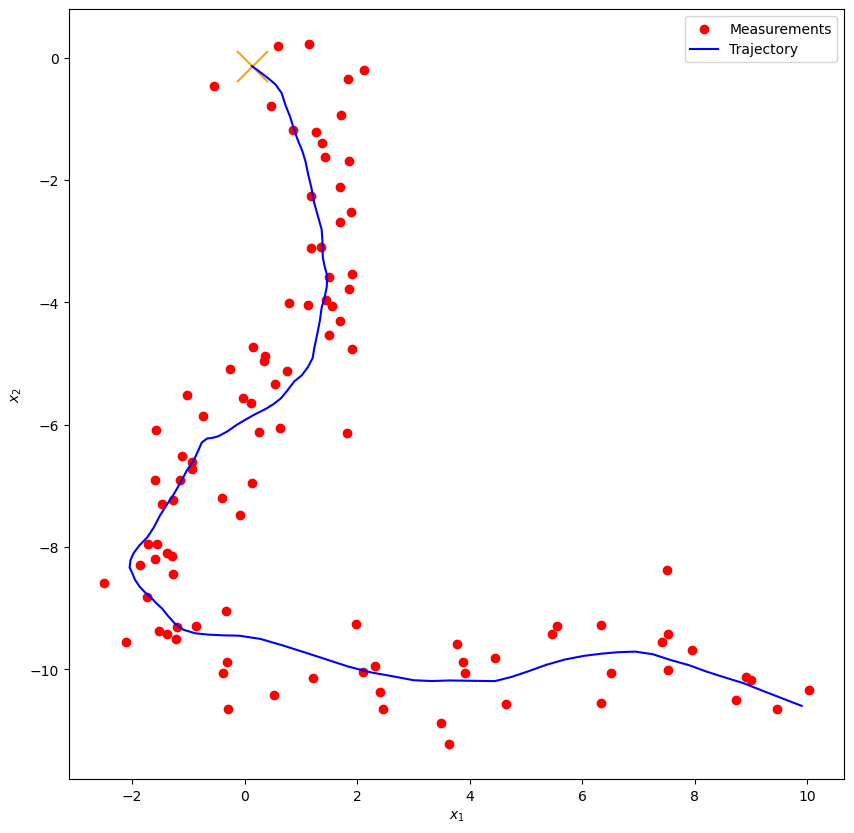

In [11]:
#loading data from file
with open("car_track.json") as fp:
    jsondata = json.load(fp)
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"]).T
    steps = states.shape[0]

plot_car_trajectory(observations, states, "Trajectory")

In [12]:
trigger_threshold = 1.0

Trigger at step 4, delta = 1.571
Trigger at step 9, delta = 1.198
Trigger at step 15, delta = 1.239
Trigger at step 21, delta = 1.212
Trigger at step 29, delta = 1.461
Trigger at step 33, delta = 1.103
Trigger at step 38, delta = 1.214
Trigger at step 45, delta = 1.125
Trigger at step 54, delta = 1.068
Trigger at step 63, delta = 1.250
Trigger at step 67, delta = 1.195
Trigger at step 72, delta = 1.057
Trigger at step 74, delta = 1.320
Trigger at step 77, delta = 1.269
Trigger at step 79, delta = 1.159
Trigger at step 82, delta = 1.070
Trigger at step 86, delta = 1.469
Trigger at step 89, delta = 1.189
Trigger at step 92, delta = 1.210
Trigger at step 96, delta = 1.035
Trigger at step 98, delta = 1.012
RAW RMSE: 0.7679855237247215
KF RMSE: 0.4667339866110587


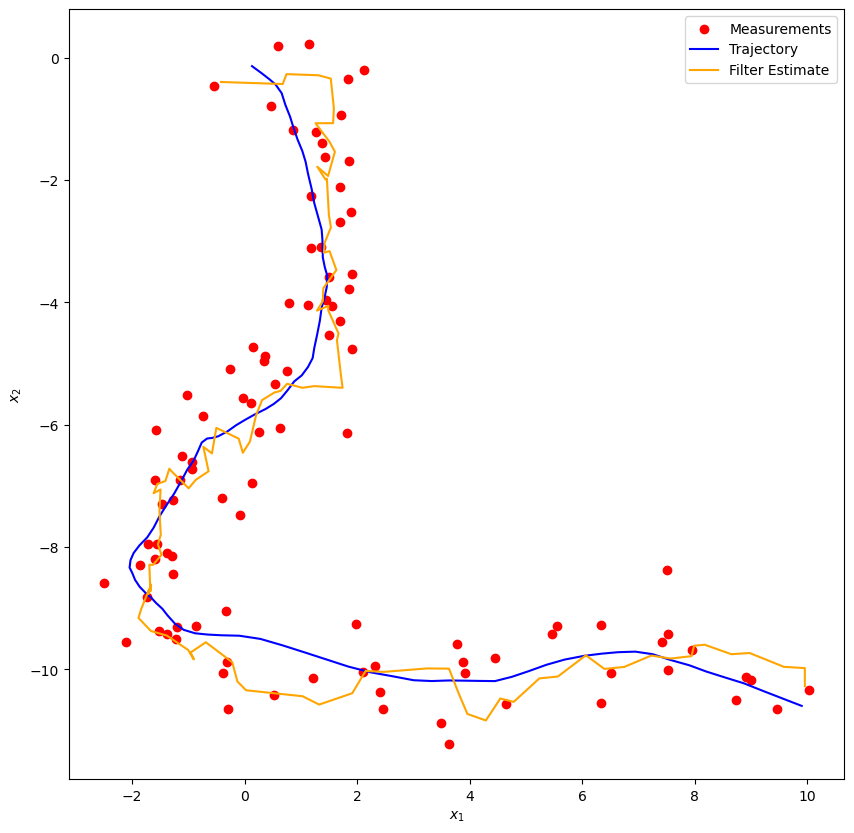

In [19]:
#implementation of kalman filter
def kalman_filter_delta(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]              #Number of state variables
    steps, N = observations.shape  # Total time steps and observation dimension
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0 # Initial state estimate
    P = P_0 # Initial covariance estimate
    
    prev_m = m.copy()
    
    triggered_steps = []
    
    for i in range(steps):
        y = observations[i]
        
        #Prediction Step
        m = A @ m                     #predict state
        P = A @ P @ A.T + Q        #predict the covariance
        
        #delta trigger
        delta = np.linalg.norm(m[:2] - prev_m[:2])
        if delta > trigger_threshold:
            print(f"Trigger at step {i}, delta = {delta:.3f}")
        
            triggered_steps.append(i)
            # Optionally: skip update step
            kf_m[i] = m
            kf_P[i] = P
            prev_m = m.copy()
            continue

        
        #Measurement Update Step 
        S = H @ P @ H.T + R
        
        #Compute Kalman Gain (efficient and stable computation)
        K = linalg.solve(S.T, H @ P, assume_a="pos").T  # K = P @ H.T @ inv(S)
        
        m = m + K @ (y - H @ m)  #update state estimate xhat equation
        
        P = P - K @ S @ K.T   #update covariance P_(n|n) equation
        
        kf_m[i] = m #storing the current state estimate
        kf_P[i] = P #storing the covariance estimate
    
    return kf_m, kf_P


m_0 = x_0
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

kf_m, kf_P = kalman_filter_delta(m_0, P_0, A, Q, H, R, observations)

plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")


In [ ]:
# Li, X., & Hao, G. (2023). Event-triggered Kalman filter and its performance analysis. Sensors, 23(4), 2202

In [ ]:
#Miskowicz, M. (2006). Send-on-delta concept: An event-based data reporting strategy. Sensors, 6(1), 49–63. https://www.mdpi.com/1424-8220/6/1/49
#Chen, W., Liu, S., Lauer, M., & Henzinger, T. A. (2017). Event-triggered state estimation: Experimental performance assessment and comparative study. IEEE Transactions on Control Systems Technology, 25(5), 1865–1877.